# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
###
#!pip install openslide-python
#https://github.com/deroneriksson/python-wsi-preprocessing/
###
sys.path.append('../python-wsi-preprocessing/')
from deephistopath.wsi import slide, filter, tiles, util

import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *

import pandas as pd
import numpy as np
import os
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm

PATH = Path('/home/Deep_Learner/work/network/datasets/Hypophysenadenome/')
FONT_PATH=PATH/'1984-Happines-Regular.ttf'
ROIS_CORTICOTROP = PATH/'rois_corticotrop'
ROIS_CORTICOTROP_FILTERED = PATH/'rois_corticotrop_filtered'
TILES = PATH/'tiles'
slide.BASE_DIR = PATH
slide.TRAIN_PREFIX = 'hypophysen'
slide.SRC_TRAIN_DIR = ROIS_CORTICOTROP

def show(np):
    return util.np_to_pil(np)

Path.ls = lambda x: list(x.iterdir())

def show_multiple_images(path, rows = 3, figsize=(24, 12)):
    imgs = [open_image(p) for p in path.ls()]
    show_all(imgs=imgs, r=rows, figsize=figsize)

# Overwrite parts of wsi lib

In [175]:
slide.SCALE_FACTOR = 1
slide.BASE_DIR = PATH/'data'
tiles.SUMMARY_TITLE_FONT_PATH = str(FONT_PATH)
tiles.FONT_PATH = str(FONT_PATH)
tiles.DISPLAY_TILE_SUMMARY_LABELS = True
tiles.LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY = True
tiles.BORDER_ALL_TILES_IN_TOP_TILE_SUMMARY = True
tiles.TISSUE_LOW_THRESH = 20

##################################################################################################################

slide.open_slide = slide.open_image

##################################################################################################################

def get_image_path(folder_path, slide_num):
    return folder_path.ls()[slide_num]

slide.get_filter_image_result = partial(get_image_path, ROIS_CORTICOTROP_FILTERED)
slide.get_training_image_path = partial(get_image_path, ROIS_CORTICOTROP)
slide.get_training_slide_path = partial(get_image_path, ROIS_CORTICOTROP)

##################################################################################################################

def parse_dimensions_from_image_filename(img_path):
    shape = slide.open_image_np(img_path).shape
    return shape[1], shape[0], shape[1], shape[0]

slide.parse_dimensions_from_image_filename = parse_dimensions_from_image_filename

##################################################################################################################

def tile_to_pil_tile(tile):
  """
  Convert tile information into the corresponding tile as a PIL image read from the whole-slide image file.

  Args:
    tile: Tile object.

  Return:
    Tile as a PIL image.
  """
  t = tile
  filepath = slide.get_training_image_path(t.slide_num)
  img = slide.open_image_np(filepath)
  x, y = t.o_c_s, t.o_r_s
  w, h = t.o_c_e - t.o_c_s, t.o_r_e - t.o_r_s
  tile = img[t.o_r_s:t.o_r_e, t.o_c_s:t.o_c_e,:]
  tile_pil = util.np_to_pil(tile)
  return tile_pil

tiles.tile_to_pil_tile = tile_to_pil_tile

##################################################################################################################
def get_tile_image_path(tile):
  """
  Obtain tile image path based on tile information such as row, column, row pixel position, column pixel position,
  pixel width, and pixel height.

  Args:
    tile: Tile object.

  Returns:
    Path to image tile.
  """
  t = tile
  roi_name = slide.get_training_image_path(t.slide_num).stem
  tile_path = os.path.join(PATH, 'tiles',
                           roi_name + "-" + 'tile' + "-r%d-c%d-x%d-y%d-w%d-h%d" % (
                             t.r, t.c, t.o_c_s, t.o_r_s, t.o_c_e - t.o_c_s, t.o_r_e - t.o_r_s) + "." + 'png')
  return tile_path

slide.get_tile_image_path = get_tile_image_path

##################################################################################################################

def top_tiles(self):
    """
    Retrieve the top-scoring tiles.

    Returns:
       List of the top-scoring tiles.
    """
    sorted_tiles = self.tiles_by_score()
    top_tiles = [tile for tile in sorted_tiles
                 if check_tile(tile)]
    print(f'Number of top tiles/all tiles: {len(top_tiles)}/{len(sorted_tiles)}')
    return top_tiles

def check_tile(tile):
    width = tile.o_c_e - tile.o_c_s
    height = tile.o_r_e - tile.o_r_s
    return tile.score > 0.45 and width >= 0.7*tiles.COL_TILE_SIZE and height >= 0.7*tiles.ROW_TILE_SIZE


tiles.TileSummary.top_tiles = top_tiles

##################################################################################################################
from deephistopath.wsi.tiles import (hsv_saturation_and_value_factor, 
                                     hsv_purple_pink_factor, 
                                     tissue_quantity_factor, 
                                     tissue_quantity)

def score_tile(np_tile, tissue_percent, slide_num, row, col):
  """
  Score tile based on tissue percentage, color factor, saturation/value factor, and tissue quantity factor.

  Args:
    np_tile: Tile as NumPy array.
    tissue_percent: The percentage of the tile judged to be tissue.
    slide_num: Slide number.
    row: Tile row.
    col: Tile column.

  Returns tuple consisting of score, color factor, saturation/value factor, and tissue quantity factor.
  """
  color_factor = hsv_purple_pink_factor(np_tile)
  s_and_v_factor = hsv_saturation_and_value_factor(np_tile)
  amount = tissue_quantity(tissue_percent)
  quantity_factor = tissue_quantity_factor(amount)
  combined_factor = color_factor * s_and_v_factor
  score = tissue_percent * combined_factor / 1000.0
  # scale score to between 0 and 1
  score = 1.0 - (10.0 / (10.0 + score))
  print(f'tp: {tissue_percent}')
  print(f'cf: {combined_factor}')
  print(f'score: {score}')  
  return score, color_factor, s_and_v_factor, quantity_factor

tiles.score_tile = score_tile
#############################################################################################################

# Filter images

In [176]:
for img_path in tqdm(ROIS_CORTICOTROP.ls()):
    if img_path.suffix == '.tif':
        img_pil = slide.open_image(img_path)
        img_np = util.pil_to_np_rgb(img_pil)
        grayscale_np = filter.filter_rgb_to_grayscale(img_np)
        complement_np = filter.filter_complement(grayscale_np)
        otsu_np = filter.filter_otsu_threshold(complement_np).astype(np.bool)
        filtered_img_np = util.mask_rgb(img_np, otsu_np)
        filtered_img_pil = util.np_to_pil(filtered_img_np)
        filtered_path = ROIS_CORTICOTROP_FILTERED/img_path.name
        filtered_img_pil.save(filtered_path)

RGB                  | Time: 0:00:00.051030  Type: uint8   Shape: (3392, 4672, 3)
Gray                 | Time: 0:00:00.504159  Type: uint8   Shape: (3392, 4672)
Complement           | Time: 0:00:00.002366  Type: uint8   Shape: (3392, 4672)
Otsu Threshold       | Time: 0:00:00.140456  Type: uint8   Shape: (3392, 4672)
Mask RGB             | Time: 0:00:00.042214  Type: uint8   Shape: (3392, 4672, 3)
RGB                  | Time: 0:00:00.067522  Type: uint8   Shape: (4672, 4416, 3)
Gray                 | Time: 0:00:00.653657  Type: uint8   Shape: (4672, 4416)
Complement           | Time: 0:00:00.003571  Type: uint8   Shape: (4672, 4416)
Otsu Threshold       | Time: 0:00:00.177429  Type: uint8   Shape: (4672, 4416)
Mask RGB             | Time: 0:00:00.046746  Type: uint8   Shape: (4672, 4416, 3)
RGB                  | Time: 0:00:00.059483  Type: uint8   Shape: (4288, 4544, 3)
Gray                 | Time: 0:00:00.614441  Type: uint8   Shape: (4288, 4544)
Complement           | Time: 0:00:00.

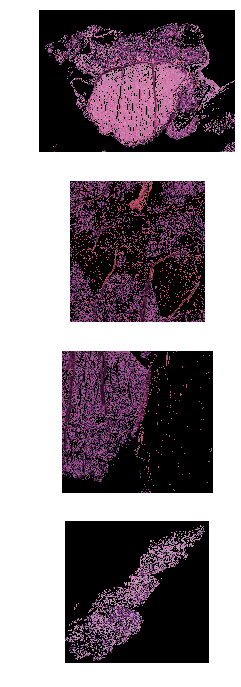

In [181]:
show_multiple_images(ROIS_CORTICOTROP_FILTERED, rows=4)

# Create tiles

In [182]:
!rm -r {TILES/'*'}
for n, p in tqdm(enumerate(ROIS_CORTICOTROP_FILTERED.ls()), total=len(ROIS_CORTICOTROP_FILTERED.ls())-1):
    if p.suffix == '.tif':
        tiles.summary_and_tiles(n, display=True, save_summary=False, save_data=False, save_top_tiles=True)

RGB                  | Time: 0:00:00.065167  Type: uint8   Shape: (3392, 4672, 3)
RGB                  | Time: 0:00:00.054131  Type: uint8   Shape: (3392, 4672, 3)
tp: 16.40157699584961
cf: 1011.8945045924492
score: 0.624013019542182
tp: 30.55744171142578
cf: 681.7117488953998
score: 0.6756549915548995
tp: 37.32318878173828
cf: 812.3619478470531
score: 0.7519837476927013
tp: 32.100582122802734
cf: 755.6134726129789
score: 0.7080772030871163
tp: 0.0003390842013857309
cf: 0.0
score: 0.0
tp: 14.958572387695312
cf: 535.6432246860775
score: 0.4448286831529942
tp: 73.15196990966797
cf: 193.0370269094615
score: 0.5854241564977245
tp: 87.82844543457031
cf: 86.88844626936798
score: 0.43282611304435537
tp: 75.0091552734375
cf: 252.6883810725163
score: 0.654623885204569
tp: 12.717861599392364
cf: 223.11196803964836
score: 0.22103256510848734
tp: 2.1401405334472656
cf: 469.20829091652865
score: 0.09125372731695225
tp: 69.42625045776367
cf: 50.83907251485209
score: 0.260878001121286
tp: 85.98642349

Save Tile            | Time: 0:00:00.421765  Name: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles/1002-17-III-HE.ndpi_[0]_2-tile-r4-c3-x2048-y3072-w1024-h1024.png
RGB                  | Time: 0:00:00.058230  Type: uint8   Shape: (4288, 4544, 3)
RGB                  | Time: 0:00:00.058071  Type: uint8   Shape: (4288, 4544, 3)
tp: 73.09732437133789
cf: 694.1321938203872
score: 0.8353616940781107
tp: 74.51772689819336
cf: 729.9134909112298
score: 0.8446999851747834
tp: 42.466163635253906
cf: 583.0014921133107
score: 0.7122950985704282
tp: 3.028583526611328
cf: 4.75390265112515
score: 0.0014376891994863916
tp: 0.8983067103794582
cf: 4.085914296889512
score: 0.0003669057538500109
tp: 75.2340316772461
cf: 740.8814371904593
score: 0.8478844472796834
tp: 71.45547866821289
cf: 794.1747315148386
score: 0.8501830813382493
tp: 41.327762603759766
cf: 366.3346521151332
score: 0.6022242274514354
tp: 1.4963150024414062
cf: 5.513054966307901
score: 0.000824246742403778
tp: 1.098196847

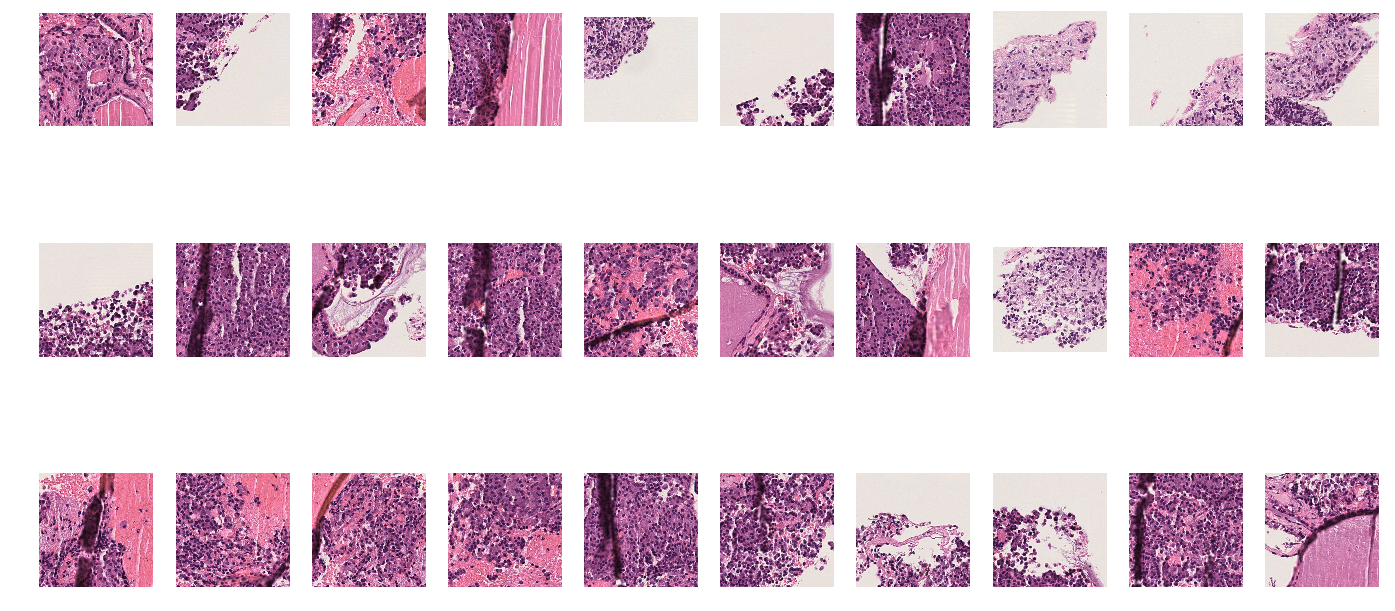

In [183]:
show_multiple_images(TILES)

# obsolete

## constants 

In [ ]:
TISSUE_HIGH_THRESH = 80
TISSUE_LOW_THRESH = 10

ROW_TILE_SIZE = 1024
COL_TILE_SIZE = 1024
NUM_TOP_TILES = 50

DISPLAY_TILE_SUMMARY_LABELS = False
TILE_LABEL_TEXT_SIZE = 10
LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY = False
BORDER_ALL_TILES_IN_TOP_TILE_SUMMARY = False

TILE_BORDER_SIZE = 2  # The size of the colored rectangular border around summary tiles.

HIGH_COLOR = (0, 255, 0)
MEDIUM_COLOR = (255, 255, 0)
LOW_COLOR = (255, 165, 0)
NONE_COLOR = (255, 0, 0)

FADED_THRESH_COLOR = (128, 255, 128)
FADED_MEDIUM_COLOR = (255, 255, 128)
FADED_LOW_COLOR = (255, 210, 128)
FADED_NONE_COLOR = (255, 128, 128)

FONT_PATH = "/Library/Fonts/Arial Bold.ttf"
SUMMARY_TITLE_FONT_PATH = "/Library/Fonts/Courier New Bold.ttf"
SUMMARY_TITLE_TEXT_COLOR = (0, 0, 0)
SUMMARY_TITLE_TEXT_SIZE = 24
SUMMARY_TILE_TEXT_COLOR = (255, 255, 255)
TILE_TEXT_COLOR = (0, 0, 0)
TILE_TEXT_SIZE = 36
TILE_TEXT_BACKGROUND_COLOR = (255, 255, 255)
TILE_TEXT_W_BORDER = 5
TILE_TEXT_H_BORDER = 4

HSV_PURPLE = 270
HSV_PINK = 330

## score_tile

In [ ]:
def score_tile(np_tile, tissue_percent, row, col):
    """
    Score tile based on tissue percentage, color factor, saturation/value factor, and tissue quantity factor.  
    
    Args:
    np_tile: Tile as NumPy array.
    tissue_percent: The percentage of the tile judged to be tissue.
    row: Tile row.
    col: Tile column.
    
    Returns tuple consisting of score, color factor, saturation/value factor, and tissue quantity factor.
    """
    color_factor = tiles.hsv_purple_pink_factor(np_tile)
    s_and_v_factor = tiles.hsv_saturation_and_value_factor(np_tile)
    amount = tiles.tissue_quantity(tissue_percent)
    quantity_factor = tiles.tissue_quantity_factor(amount)
    combined_factor = color_factor * s_and_v_factor * quantity_factor
    score = (tissue_percent ** 2) * np.log(1 + combined_factor) / 1000.0
    # scale score to between 0 and 1
    score = 1.0 - (10.0 / (10.0 + score))
    return score, color_factor, s_and_v_factor, quantity_factor

## score_tiles

In [ ]:
def score_tiles(img_path, np_img=None, dimensions=None, small_tile_in_tile=False, tile_size=1024):
    """
     Score all tiles for a slide and return the results in a TileSummary object.
     Args:
       img_path: 
       np_img: Optional image as a NumPy array.
       dimensions: Optional tuple consisting of (original width, original height, new width, new height). Used for dynamic
         tile retrieval.
       small_tile_in_tile: If True, include the small NumPy image in the Tile objects.
     Returns:
       TileSummary object which includes a list of Tile objects containing information about each tile.
     """
    if np_img is None:
        np_img = slide.open_image_np(img_path)
   
    if dimensions is None:
        h, w = slide.open_image_np(img_path).shape[:2]
        o_h, o_w = h, w
    else:
        o_w, o_h, w, h = dimensions
        
    num_row_tiles, num_col_tiles = tiles.get_num_tiles(h, w, tile_size, tile_size)
    tile_sum = tiles.TileSummary(slide_num=None,
                        orig_w=o_w,
                        orig_h=o_h,
                        orig_tile_w=tile_size,
                        orig_tile_h=tile_size,
                        #scale_factor = None,                    
                        scaled_w=w,
                        scaled_h=h,
                        scaled_tile_w=tile_size,
                        scaled_tile_h=tile_size,
                        tissue_percentage=filter.tissue_percent(np_img),
                        num_col_tiles=num_col_tiles,
                        num_row_tiles=num_row_tiles)
    count = 0
    high = 0
    medium = 0
    low = 0
    none = 0
    tile_indices = tiles.get_tile_indices(h, w, tile_size, tile_size)
    for t in tile_indices:
        count += 1  # tile_num
        r_s, r_e, c_s, c_e, r, c = t
        np_tile = np_img[r_s:r_e, c_s:c_e]
        t_p = filter.tissue_percent(np_tile)
        amount = tiles.tissue_quantity(t_p)
        if amount == tiles.TissueQuantity.HIGH:
            high += 1
        elif amount == tiles.TissueQuantity.MEDIUM:
            medium += 1
        elif amount == tiles.TissueQuantity.LOW:
            low += 1
        elif amount == tiles.TissueQuantity.NONE:
            none += 1
        o_c_s, o_r_s = slide.small_to_large_mapping((c_s, r_s), (o_w, o_h))
        o_c_e, o_r_e = slide.small_to_large_mapping((c_e, r_e), (o_w, o_h))
        # pixel adjustment in case tile dimension too large (for example, 1025 instead of 1024)
        if (o_c_e - o_c_s) > tile_size:
            o_c_e -= 1
        if (o_r_e - o_r_s) > tile_size:
            o_r_e -= 1
        score, color_factor, s_and_v_factor, quantity_factor = score_tile(np_tile, t_p, r, c)
        np_scaled_tile = np_tile if small_tile_in_tile else None
        tile = tiles.Tile(tile_sum, None, np_scaled_tile, count, r, c, r_s, r_e, c_s, c_e, o_r_s, o_r_e, o_c_s,
               o_c_e, t_p, color_factor, s_and_v_factor, quantity_factor, score)
        tile_sum.tiles.append(tile)
        
    tile_sum.count = count
    tile_sum.high = high
    tile_sum.medium = medium
    tile_sum.low = low
    tile_sum.none = none
    tiles_by_score = tile_sum.tiles_by_score()
    rank = 0
    for t in tiles_by_score:
        rank += 1
        t.rank = rank
    return tile_sum

## generate_tile_summaries

In [64]:
def generate_tile_summaries(tile_sum, np_img, img_path, display=True, save_summary=False):
  """
  Generate summary images/thumbnails showing a 'heatmap' representation of the tissue segmentation of all tiles.

  Args:
    tile_sum: TileSummary object.
    np_img: Image as a NumPy array.
    display: If True, display tile summary to screen.
    save_summary: If True, save tile summary images.
  """
  z = 300  # height of area at top of summary slide
  slide_num = tile_sum.slide_num
  rows = tile_sum.scaled_h
  cols = tile_sum.scaled_w
  row_tile_size = tile_sum.scaled_tile_h
  col_tile_size = tile_sum.scaled_tile_w
  num_row_tiles, num_col_tiles = tiles.get_num_tiles(rows, cols, row_tile_size, col_tile_size)
  summary = tiles.create_summary_pil_img(np_img, z, row_tile_size, col_tile_size, num_row_tiles, num_col_tiles)
  draw = ImageDraw.Draw(summary)

  #original_img_path = slide.get_training_image_path(slide_num)
  original_img_path = img_path
  np_orig = slide.open_image_np(original_img_path)
  summary_orig = tiles.create_summary_pil_img(np_orig, z, row_tile_size, col_tile_size, num_row_tiles, num_col_tiles)
  draw_orig = ImageDraw.Draw(summary_orig)

  for t in tile_sum.tiles:
    border_color = tile_border_color(t.tissue_percentage)
    tile_border(draw, t.r_s + z, t.r_e + z, t.c_s, t.c_e, border_color)
    tile_border(draw_orig, t.r_s + z, t.r_e + z, t.c_s, t.c_e, border_color)

  summary_txt = summary_title(tile_sum) + "\n" + summary_stats(tile_sum)

  summary_font = ImageFont.truetype(SUMMARY_TITLE_FONT_PATH, size=SUMMARY_TITLE_TEXT_SIZE)
  draw.text((5, 5), summary_txt, SUMMARY_TITLE_TEXT_COLOR, font=summary_font)
  draw_orig.text((5, 5), summary_txt, SUMMARY_TITLE_TEXT_COLOR, font=summary_font)

  if DISPLAY_TILE_SUMMARY_LABELS:
    count = 0
    for t in tile_sum.tiles:
      count += 1
      label = "R%d\nC%d" % (t.r, t.c)
      font = ImageFont.truetype(FONT_PATH, size=TILE_LABEL_TEXT_SIZE)
      # drop shadow behind text
      draw.text(((t.c_s + 3), (t.r_s + 3 + z)), label, (0, 0, 0), font=font)
      draw_orig.text(((t.c_s + 3), (t.r_s + 3 + z)), label, (0, 0, 0), font=font)

      draw.text(((t.c_s + 2), (t.r_s + 2 + z)), label, SUMMARY_TILE_TEXT_COLOR, font=font)
      draw_orig.text(((t.c_s + 2), (t.r_s + 2 + z)), label, SUMMARY_TILE_TEXT_COLOR, font=font)

  if display:
    summary.show()
    summary_orig.show()
  if save_summary:
    save_tile_summary_image(summary, slide_num)
    save_tile_summary_on_original_image(summary_orig, slide_num)

## generate_top_tile_summaries

In [65]:
def generate_top_tile_summaries(tile_sum, np_img, display=True, save_summary=False, show_top_stats=True,
                                label_all_tiles=LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY,
                                border_all_tiles=BORDER_ALL_TILES_IN_TOP_TILE_SUMMARY):
  """
  Generate summary images/thumbnails showing the top tiles ranked by score.

  Args:
    tile_sum: TileSummary object.
    np_img: Image as a NumPy array.
    display: If True, display top tiles to screen.
    save_summary: If True, save top tiles images.
    show_top_stats: If True, append top tile score stats to image.
    label_all_tiles: If True, label all tiles. If False, label only top tiles.
  """
  z = 300  # height of area at top of summary slide
  slide_num = tile_sum.slide_num
  rows = tile_sum.scaled_h
  cols = tile_sum.scaled_w
  row_tile_size = tile_sum.scaled_tile_h
  col_tile_size = tile_sum.scaled_tile_w
  num_row_tiles, num_col_tiles = get_num_tiles(rows, cols, row_tile_size, col_tile_size)
  summary = create_summary_pil_img(np_img, z, row_tile_size, col_tile_size, num_row_tiles, num_col_tiles)
  draw = ImageDraw.Draw(summary)

  original_img_path = slide.get_training_image_path(slide_num)
  np_orig = slide.open_image_np(original_img_path)
  summary_orig = create_summary_pil_img(np_orig, z, row_tile_size, col_tile_size, num_row_tiles, num_col_tiles)
  draw_orig = ImageDraw.Draw(summary_orig)

  if border_all_tiles:
    for t in tile_sum.tiles:
      border_color = faded_tile_border_color(t.tissue_percentage)
      tile_border(draw, t.r_s + z, t.r_e + z, t.c_s, t.c_e, border_color, border_size=1)
      tile_border(draw_orig, t.r_s + z, t.r_e + z, t.c_s, t.c_e, border_color, border_size=1)

  tbs = TILE_BORDER_SIZE
  top_tiles = tile_sum.top_tiles()
  for t in top_tiles:
    border_color = tile_border_color(t.tissue_percentage)
    tile_border(draw, t.r_s + z, t.r_e + z, t.c_s, t.c_e, border_color)
    tile_border(draw_orig, t.r_s + z, t.r_e + z, t.c_s, t.c_e, border_color)
    if border_all_tiles:
      tile_border(draw, t.r_s + z + tbs, t.r_e + z - tbs, t.c_s + tbs, t.c_e - tbs, (0, 0, 0))
      tile_border(draw_orig, t.r_s + z + tbs, t.r_e + z - tbs, t.c_s + tbs, t.c_e - tbs, (0, 0, 0))

  summary_title = "Slide %03d Top Tile Summary:" % slide_num
  summary_txt = summary_title + "\n" + summary_stats(tile_sum)

  summary_font = ImageFont.truetype(SUMMARY_TITLE_FONT_PATH, size=SUMMARY_TITLE_TEXT_SIZE)
  draw.text((5, 5), summary_txt, SUMMARY_TITLE_TEXT_COLOR, font=summary_font)
  draw_orig.text((5, 5), summary_txt, SUMMARY_TITLE_TEXT_COLOR, font=summary_font)

  tiles_to_label = tile_sum.tiles if label_all_tiles else top_tiles
  h_offset = TILE_BORDER_SIZE + 2
  v_offset = TILE_BORDER_SIZE
  h_ds_offset = TILE_BORDER_SIZE + 3
  v_ds_offset = TILE_BORDER_SIZE + 1
  for t in tiles_to_label:
    label = "R%d\nC%d" % (t.r, t.c)
    font = ImageFont.truetype(FONT_PATH, size=TILE_LABEL_TEXT_SIZE)
    # drop shadow behind text
    draw.text(((t.c_s + h_ds_offset), (t.r_s + v_ds_offset + z)), label, (0, 0, 0), font=font)
    draw_orig.text(((t.c_s + h_ds_offset), (t.r_s + v_ds_offset + z)), label, (0, 0, 0), font=font)

    draw.text(((t.c_s + h_offset), (t.r_s + v_offset + z)), label, SUMMARY_TILE_TEXT_COLOR, font=font)
    draw_orig.text(((t.c_s + h_offset), (t.r_s + v_offset + z)), label, SUMMARY_TILE_TEXT_COLOR, font=font)

  if show_top_stats:
    summary = add_tile_stats_to_top_tile_summary(summary, top_tiles, z)
    summary_orig = add_tile_stats_to_top_tile_summary(summary_orig, top_tiles, z)

  if display:
    summary.show()
    summary_orig.show()
  if save_summary:
    save_top_tiles_image(summary, slide_num)
    save_top_tiles_on_original_image(summary_orig, slide_num)

NameError: name 'LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY' is not defined

## summary_and_tiles

In [66]:
def summary_and_tiles(img_path, display=True, save_summary=False, save_data=False, save_top_tiles=False):
    """
    Generate tile summary and top tiles for slide.
    Args:
    img_path: 
    display: If True, display tile summary to screen.
    save_summary: If True, save tile summary images.
    save_data: If True, save tile data to csv file.
    save_top_tiles: If True, save top tiles to files.
    """
    np_img = slide.open_image_np(img_path)
    tile_sum = score_tiles(img_path, np_img)
    if save_data:
        save_tile_data(tile_sum)
    generate_tile_summaries(tile_sum, np_img, img_path, display=display, save_summary=save_summary)
    generate_top_tile_summaries(tile_sum, np_img, display=display, save_summary=save_summary)
    if save_top_tiles:
        for tile in tile_sum.top_tiles():
            tile.save_tile()
    return tile_sum